In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from cv2 import IMREAD_GRAYSCALE
import os
from scipy.signal import convolve

In [2]:
def gaussian1d(sigma, mean, x, ord):
    x = np.array(x)
    x_ = x - mean
    var = sigma**2

    # Gaussian Function
    g1 = (1/np.sqrt(2*np.pi*var))*(np.exp((-1*x_*x_)/(2*var)))
    
    if ord == 0:
        g = g1
        return g
    elif ord == 1:
        g = -g1*((x_)/(var))
        return g
    else:
        g = g1*(((x_*x_) - var)/(var**2))
        return g

def gaussian2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    return g

def log2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    h = g*((x*x + y*y) - var)/(var**2)
    return h

def makefilter(scale, phasex, phasey, pts, sup):

    gx = gaussian1d(3*scale, 0, pts[0,...], phasex)
    gy = gaussian1d(scale,   0, pts[1,...], phasey)

    image = gx*gy

    image = np.reshape(image,(sup,sup))
    return image

def makeLMfilters():
    sup     = 49
    scalex  = np.sqrt(2) * np.array([1,2,3])
    norient = 6
    nrotinv = 12

    nbar  = len(scalex)*norient
    nedge = len(scalex)*norient
    nf    = nbar+nedge+nrotinv
    F     = np.zeros([sup,sup,nf])
    hsup  = (sup - 1)/2

    x = [np.arange(-hsup,hsup+1)]
    y = [np.arange(-hsup,hsup+1)]

    [x,y] = np.meshgrid(x,y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)
    
    count = 0
    for scale in range(len(scalex)):
        for orient in range(norient):
            angle = (np.pi * orient)/norient
            c = np.cos(angle)
            s = np.sin(angle)
            rotpts = [[c+0,-s+0],[s+0,c+0]]
            rotpts = np.array(rotpts)
            rotpts = np.dot(rotpts,orgpts)
            F[:,:,count] = makefilter(scalex[scale], 0, 1, rotpts, sup)
            F[:,:,count+nedge] = makefilter(scalex[scale], 0, 2, rotpts, sup)
            count = count + 1
            
    count = nbar+nedge
    scales = np.sqrt(2) * np.array([1,2,3,4])
    
    for i in range(len(scales)):
        F[:,:,count]   = gaussian2d(sup, scales[i])
        count = count + 1
        
    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, scales[i])
        count = count + 1
        
    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, 3*scales[i])
        count = count + 1
        
    return F

In [3]:
def feature_engineering(img, img_name, inferrence= False):
    df = pd.DataFrame()

    df['og_pixels'] = img.reshape(-1)
    df['img'] = img_name

    # num = 1
    # kernels = []
    # for theta in range(2):
    #     theta = theta / 4. * np.pi
    #     for sigma in (1, 3):
    #         for lamda in np.arange(0, np.pi, np.pi / 4):
    #             for gamma in (0.05, 0.5):
    #                 gabor_label = 'gabor_' + str(num)
    #                 ksize = 9
    #                 kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype= cv2.CV_32F)
    #                 kernels.append(kernel)
    #                 fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
    #                 filtered_img = fimg.reshape(-1)
    #                 df[gabor_label] = filtered_img
    #                 num += 1

    F = makeLMfilters()
    _, _, num_filters = F.shape
    for i in range(num_filters):
        df[f'lm_filter_{i}'] = convolve(img, F[:,:,i], mode='same').reshape(-1)

    edges = cv2.Canny(img, 100, 200)
    edges1 = edges.reshape(-1)
    df['canny'] = edges1

    from skimage.filters import roberts, sobel, scharr, prewitt, gaussian

    edge_roberts = roberts(img)
    edge_roberts1 = edge_roberts.reshape(-1)
    df['roberts'] = edge_roberts1

    edge_sobel = sobel(img)
    edge_sobel1 = edge_sobel.reshape(-1)
    df['sobel'] = edge_sobel1

    edge_scharr = scharr(img)
    edge_scharr1 = edge_scharr.reshape(-1)
    df['scharr'] = edge_scharr1

    edge_prewitt = prewitt(img)
    edge_prewitt1 = edge_prewitt.reshape(-1)
    df['prewitt'] = edge_prewitt1

    # gaussian_img = gaussian(img, 3)
    # df['gaussian_s3'] = gaussian_img.reshape(-1)

    # gaussian_img2 = gaussian(img, 7)
    # df['gaussian_s7'] = gaussian_img2.reshape(-1)


    # median_img = cv2.medianBlur(img, 3)
    # df['median_s3'] = median_img.reshape(-1)

    if inferrence:
        df = df.drop('img', axis= 1)

    return df

In [4]:
train_df = pd.DataFrame()
train_path = './train/train.tif'

In [5]:
_, train_img = cv2.imreadmulti(train_path, [])

for img_name, img in enumerate(train_img):
    img_name = str(img_name) + '.jpg'
    print(f'Loading {img_name}')
    df = feature_engineering(img, img_name)
    train_df = pd.concat([train_df, df])
train_df


Loading 0.jpg
Loading 1.jpg
Loading 2.jpg
Loading 3.jpg
Loading 4.jpg
Loading 5.jpg
Loading 6.jpg
Loading 7.jpg
Loading 8.jpg


: 

: 

In [ ]:
train_label_df = pd.DataFrame()
train_label_path = './labels/label.tif'

In [ ]:


_, train_label_img = cv2.imreadmulti(train_label_path, [])

for label_name, label_img in enumerate(train_label_img):
    label_name = str(label_name) + '.jpg'
    df = pd.DataFrame()

    df['label'] = label_img.reshape(-1)
    df['img_label'] = label_name

    train_label_df = pd.concat([train_label_df, df])
train_label_df

,label,img_label
0,0,0.jpg
1,0,0.jpg
2,0,0.jpg
3,0,0.jpg
4,0,0.jpg
...,...,...
1019899,0,8.jpg
1019900,0,8.jpg
1019901,0,8.jpg
1019902,0,8.jpg


In [ ]:
data_df = pd.concat([train_df, train_label_df], axis= 1)

data_df['img'].equals(data_df['img_label'])

True

In [ ]:
data_df = data_df[data_df['label'] != 0]

In [ ]:
group = data_df.groupby('img').ngroup() + 1
group

26434     1
26435     1
26436     1
26437     1
26438     1
         ..
914983    9
914984    9
914985    9
914986    9
914987    9
Length: 324959, dtype: int64

In [ ]:
X = data_df.drop(['img', 'img_label','label'], axis= 1).reset_index(drop= True)
# X = data_df.drop('label', axis= 1)
Y = data_df['label'].values

In [ ]:
X

,og_pixels,gabor_1,gabor_2,gabor_3,gabor_4,gabor_5,gabor_6,gabor_7,gabor_8,gabor_9,...,gabor_31,gabor_32,canny,roberts,sobel,scharr,prewitt,gaussian_s3,gaussian_s7,median_s3
0,20,0,0,41,37,19,22,15,18,0,...,32,23,0,0.057166,0.029149,0.030913,0.027185,0.044897,0.043074,14
1,4,0,0,9,4,0,0,0,0,0,...,30,20,0,0.011765,0.035646,0.037731,0.033031,0.044347,0.042900,7
2,4,0,0,32,13,13,2,11,1,0,...,14,8,0,0.029994,0.021591,0.022470,0.020419,0.045165,0.042778,7
3,13,0,0,47,35,11,14,2,7,0,...,4,0,0,0.019996,0.033391,0.034032,0.032562,0.047031,0.042705,13
4,17,0,0,74,48,21,15,4,5,0,...,9,4,0,0.011433,0.020188,0.020389,0.019953,0.049291,0.042677,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324954,154,0,0,255,255,254,146,109,66,0,...,86,55,0,0.023854,0.018653,0.018874,0.018486,0.546654,0.436508,149
324955,146,0,0,255,255,247,132,103,51,0,...,74,42,0,0.014139,0.014739,0.013660,0.016353,0.549833,0.432962,149
324956,150,0,0,255,255,226,125,86,49,0,...,66,33,0,0.011765,0.014706,0.018873,0.009150,0.551589,0.428366,149
324957,154,0,0,255,255,231,126,90,47,0,...,98,61,0,0.041595,0.034314,0.034167,0.034511,0.550889,0.422649,151


In [ ]:
X.columns

In [51]:
Y

array([1, 1, 1, ..., 3, 3, 3], dtype=uint8)

In [52]:
from sklearn.model_selection import cross_validate, LeaveOneGroupOut

def cross_validation(model, _X, _Y, _groups, _scoring, _threads= 1):
    logo = LeaveOneGroupOut()
    print('start validating')
    scores = cross_validate(model, _X, _Y, groups= _groups, scoring= _scoring, cv= logo, n_jobs= _threads, verbose= 1)
    result = {}
    for metric in scores:
        result[metric] = scores[metric]
        result[metric + '__mean'] = scores[metric].mean()
        result[metric + '__standard-deviation'] = scores[metric].std()
    return result

In [53]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators= 50, random_state= 42, verbose= 1, n_jobs= -1)

print('start training')
model.fit(X, Y)

scoring = ['accuracy', 'f1_macro', 'roc_auc_ovr', 'jaccard_macro']

score = cross_validation(model, X, Y, group, scoring, -1)



start training


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   22.8s


start validating


[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   24.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   18.2s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   19.2s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   19.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[

In [75]:
score

{'fit_time': array([19.98780417, 21.1906867 , 22.21713328, 24.15622926, 24.76947689,
        24.50481677, 22.30992484, 25.04436564, 22.55067992]),
 'fit_time__mean': 22.970124165217083,
 'fit_time__standard-deviation': 1.651319227717421,
 'score_time': array([0.57396746, 0.52391577, 0.39092731, 0.34444809, 0.21115494,
        0.25807118, 0.37187934, 0.2994628 , 0.22861314]),
 'score_time__mean': 0.3558266692691379,
 'score_time__standard-deviation': 0.11893265010434288,
 'test_accuracy': array([0.95683026, 0.96472484, 0.94597958, 0.92841445, 0.93667474,
        0.95237486, 0.93516103, 0.97358367, 0.95353885]),
 'test_accuracy__mean': 0.9496980314117344,
 'test_accuracy__standard-deviation': 0.013811680654837925,
 'test_f1_macro': array([0.94575776, 0.96143659, 0.90918665, 0.90190985, 0.93734653,
        0.96048051, 0.94315587, 0.95825003, 0.92932262]),
 'test_f1_macro__mean': 0.9385384904111989,
 'test_f1_macro__standard-deviation': 0.020432269802250585,
 'test_roc_auc_ovr': array([0.9

In [54]:
_, img_test_list = cv2.imreadmulti(train_path)
img_test = img_test_list[0]
img_test_df = feature_engineering(img_test, 'test.jpg', True)
img_test_df

,og_pixels,gabor_1,gabor_2,gabor_3,gabor_4,gabor_5,gabor_6,gabor_7,gabor_8,gabor_9,...,gabor_31,gabor_32,canny,roberts,sobel,scharr,prewitt,gaussian_s3,gaussian_s7,median_s3
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019899,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1019900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1019901,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1019902,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    3.1s finished


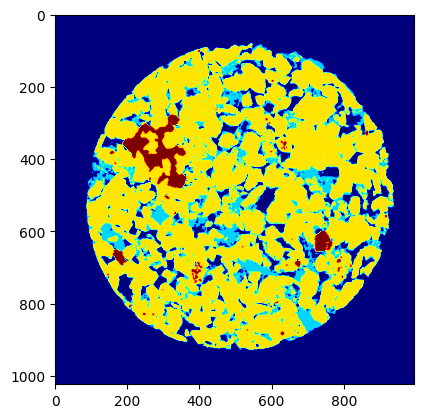

In [55]:
segmented_img_test = model.predict(img_test_df)
segmented_img_test = segmented_img_test.reshape((img_test.shape))
plt.imshow(segmented_img_test, cmap= 'jet')

In [57]:
# import pickle


# model_name = "random_forest"
# pickle.dump(model, open(model_name, 'wb'))

In [60]:
sorted(zip(img_test_df.columns, model.feature_importances_), reverse= True)

[('sobel', 0.014344531024057115),
 ('scharr', 0.015997224581804904),
 ('roberts', 0.012543002423376567),
 ('prewitt', 0.015285380636268948),
 ('og_pixels', 0.11767763902203437),
 ('median_s3', 0.18479516858506967),
 ('gaussian_s7', 0.09044961746561644),
 ('gaussian_s3', 0.157184998229169),
 ('gabor_9', 0.0),
 ('gabor_8', 0.013395006478153788),
 ('gabor_7', 0.023218422484050427),
 ('gabor_6', 0.053039452979159955),
 ('gabor_5', 0.032976679464304416),
 ('gabor_4', 0.07535402682907574),
 ('gabor_32', 0.010708052027696147),
 ('gabor_31', 0.014708557074532709),
 ('gabor_30', 0.005787950379372671),
 ('gabor_3', 0.03776335036067701),
 ('gabor_29', 0.011149016998815538),
 ('gabor_28', 0.0014511632563542053),
 ('gabor_27', 0.000765842255642666),
 ('gabor_26', 0.0),
 ('gabor_25', 0.0),
 ('gabor_24', 0.03431090996826083),
 ('gabor_23', 0.026672180516193737),
 ('gabor_22', 0.0023604341288020955),
 ('gabor_21', 0.01931008506684082),
 ('gabor_20', 9.659699756875116e-05),
 ('gabor_2', 0.0),
 ('gabor_

In [5]:
_, img_test_label_stack = cv2.imreadmulti(train_label_path)
img_test_label = img_test_label_stack[0]
img_test_label.shape

(1024, 996)

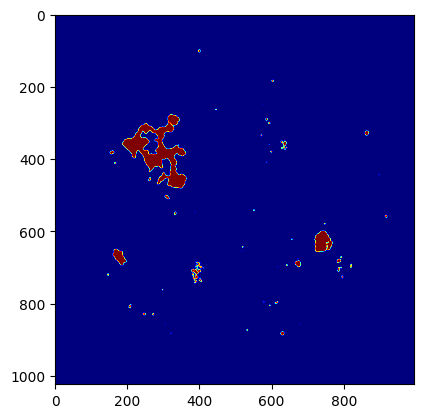

In [73]:
plt.imshow(segmented_img_test == 4, cmap= 'jet')

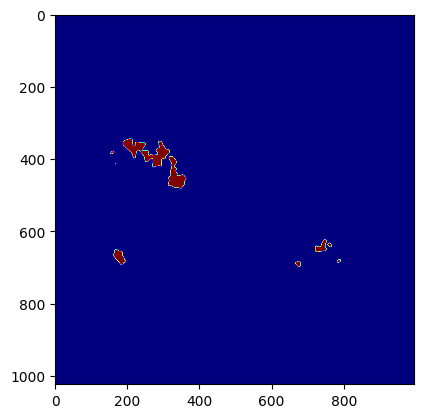

In [74]:
plt.imshow(img_test_label == 4, cmap= 'jet')